This section will introduce some basic concepts:

   - Making plots a Monte Carlo $Z \rightarrow ee$ electron $p_T$.
   - Some simple filtering techniques (requiring the electron $p_T > 50$ GeV
   - Some basics about what is going on under the hood

The following packages and methods are required for our work below.

In [1]:
# Because we aren't working from pypi yet...
import sys
sys.path = ['..'] + sys.path

from hep_tables import xaod_table, make_local
from func_adl import EventDataset
import matplotlib.pyplot as plt

# Make figures a size we can see
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

Everything has to start from a dataset. For this work here (and further on) we'll use a $Z \rightarrow ee$ MC dataset from ATLAS. This is in the binary `xAOD` format, and is on rucio, and is contains 17 files.

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

In order to use this, we need to build a computational graph around it. This `xaod_table` object establishes the connection between the the computational graphs we will build, and running things on `servicex` to actually generate the requested data.

In [3]:
df = xaod_table(dataset)

# Simple Plots

First, lets just get all the $p_T$'s of electrons from our data sample. Note that in ATLAS units are in `MeV`, but `GeV` just makes more sense. So divide the jet pt's by 1000.

In [4]:
%%time
pts = df.Electrons("Electrons").pt/1000.0

Wall time: 0 ns


This was instantanious because have built the DAG for extracting the electron $p_T$. If we want to plot it, we have to materalize it and bring the data local. Then we can plot it:

In [5]:
%%time
np_pts = make_local(pts)



Wall time: 1.73 s


The above cell did the following things:

1. Translated the DAQ into a data-query expression for `servicex`
1. Sent the query to `servicex`. `servicex` ran on 17 files that are in the $Z\rightarrow ee$ dataset, and collected their results. The package then downloaded the results locally.
1. Wrapped up the results as an in-memory JaggedArray.

i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


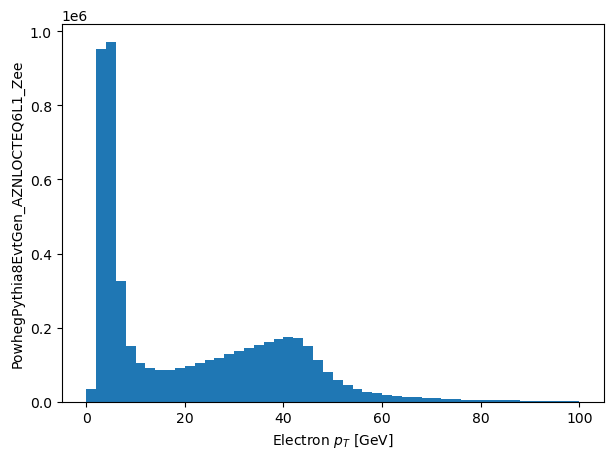

In [6]:
plt.hist(np_pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

The data that comes back is a very simple `JaggedArray` - this is from the [`awkward` array package](https://github.com/scikit-hep/awkward-array). So you can manipulate it as you normally would. Since we only pulled back the data we wanted, it is nice and small and easy to 

In [7]:
print (type(np_pts))
print (np_pts.shape)

<class 'awkward.array.jagged.JaggedArray'>
(1993800,)


In [8]:
import awkward
awkward.topandas(np_pts, flatten=True)

0        0     5.103880
         1     4.255533
         2     4.827839
1        0    39.376527
         1    24.656729
                ...    
1993796  3     4.166109
1993797  0     4.459818
1993798  0    52.486605
         1    23.942820
         2    19.794887
Length: 5248750, dtype: float64

## Filtering Single Objects

What if we only want to look at the electrons with a $p_T$ above 50 GeV? Then we use the slice operations that `numpy` and `pandas` have gotten us used to. To avoid repeating ourselves and typing long lines, it is convienient to define a few variables as short-cuts. We also want a list of _good electrons_, so lets define that.

In [9]:
%%time
eles = df.Electrons("Electrons")
good_eles = eles[(eles.pt > 50000.0) & (abs(eles.eta) < 1.5)]

np_pts_good_short = make_local(good_eles.pt/1000.0)



Wall time: 1.2 s


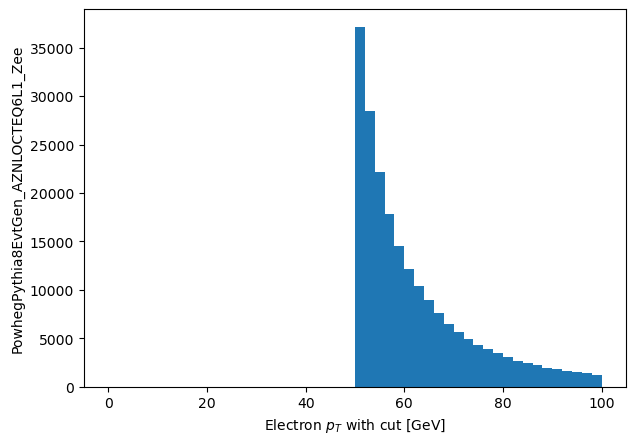

In [10]:
plt.hist(np_pts_good_short.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

So now we can look at the $\eta$ distributions before and after that cut if we like. Note we move the lists right inside the `make_local` call as we aren't going to really need those definitions elsewhere.

In [11]:
%%time
np_eta_all = make_local(eles.eta)
np_eta_good = make_local(good_eles.eta)



Wall time: 3.09 s


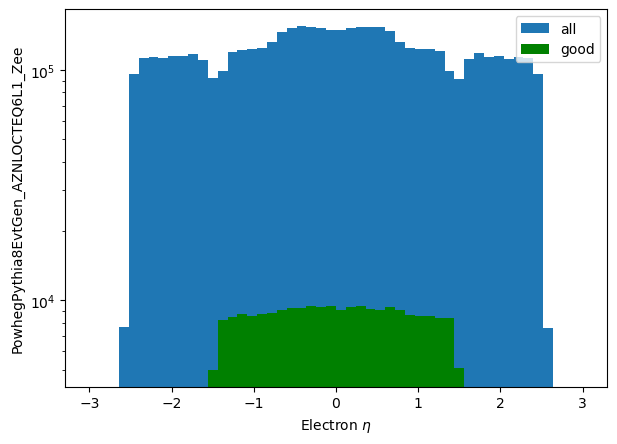

In [12]:
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.hist(np_eta_good.flatten(), label='good', bins=50, range=(-3.0,3.0), color='g')
plt.yscale('log')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
plt.xlabel('Electron $\eta$')
plt.legend();

### Filter Functions

Sometimes filters can get a bit complex or you'd like to re-use them, or define them in one file and use them in another. Filter functions are a way to do that. The function is just inserted into the filter, and will, effectively, be called as if it has a single electron as an argument:

In [13]:
def central_good_ele(e):
    return (e.pt/1000.0 > 40) & (abs(e.eta) < 1.5)

central_good_eles = eles[central_good_ele]

In [14]:
%%time
np_eta_central_good = make_local(central_good_eles.eta)



Wall time: 1.26 s


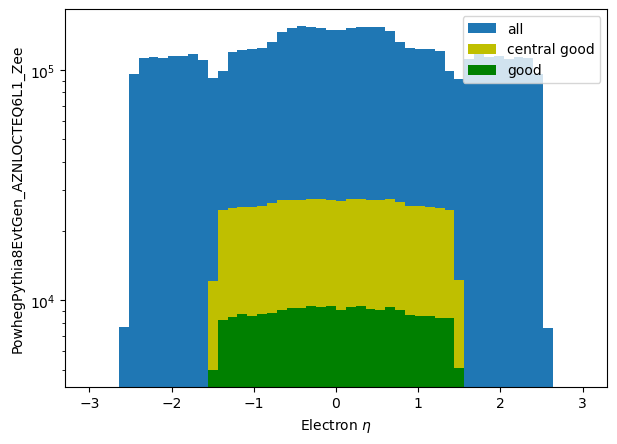

In [15]:
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.hist(np_eta_central_good.flatten(), label='central good', bins=50, range=(-3.0,3.0), color='y')
plt.hist(np_eta_good.flatten(), label='good', bins=50, range=(-3.0,3.0), color='g')
plt.yscale('log')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
plt.xlabel('Electron $\eta$')
plt.legend();

There isn't anything very magical occuring here: the function is called with an argument of whatever preceeds the filtering brackets. So `eles[central_good_ele]` is a short cut for `eles[central_good_ele(eles)]`. This is more about syntatic sugar.

## Filtering on numbers of objects

So far the selection and filtering has all been on a single object - like a single electron having $p_T > 50$ GeV. What if you want to require at least two electrons that satisfy that requirement? To count the number of objects that satisfy a requirement, after the cuts, add the `Count()` method. `Count` will always count the number of objects it is looking at. It can be used both to get back counts and also to filter:

In [16]:
%%time
electron_counts = make_local(eles.Count())
good_electron_counts = make_local(good_eles.Count())



Wall time: 1.42 s


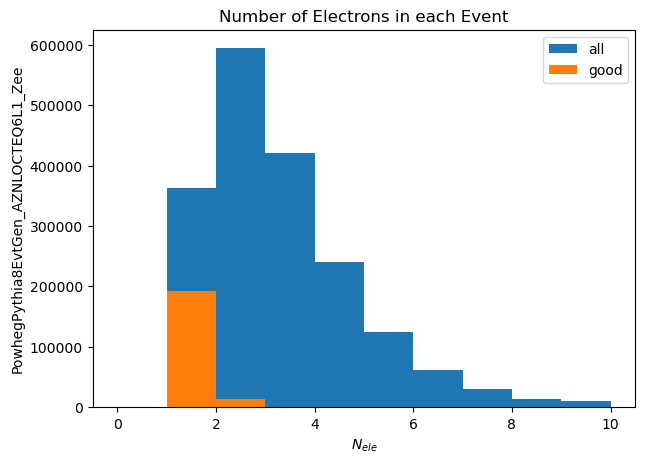

In [17]:
plt.hist(electron_counts[electron_counts>0], label='all', range=(0,10))
plt.hist(good_electron_counts[good_electron_counts>0], label='good', range=(0,10))
plt.xlabel('$N_{ele}$')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
plt.title('Number of Electrons in each Event')
_ = plt.legend()

And we can also filter on number of electrons, creating a collection of events that have only two electrons:

In [18]:
%%time
good_events = df[eles.Count() == 2]
ele_per_event_count = make_local(good_events.Electrons("Electrons").Count())



Wall time: 686 ms


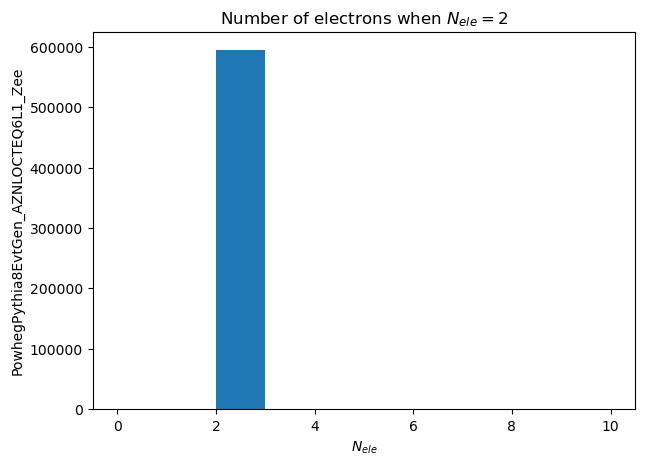

In [19]:
plt.hist(ele_per_event_count, range=(0,10))
plt.title ('Number of electrons when $N_{ele} = 2$')
plt.xlabel('$N_{ele}$')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')